## Assignment 5

The document is also available on [GitHub](https://github.com/taipeinative/terrain-hydrologic/blob/main/Assignment%201130/assignment-1130.ipynb).

Task 1: Calculate the true area of each grid.

Task 2: Calculate the volume of the Earth’s sea water, based on the sea level (0m).

Task 3: Invert the terrain of the Earth.

Task 4: What is the new sea level if you pour the sea water back?

### Surface area over an ellipsoid

An infinitesimal surface area over an ellipsoid can be derived by:

$dA = \sqrt{g_{\phi\phi}g_{\lambda\lambda} - g^{2}_{\phi\lambda}}\; d\phi d\lambda$

where

* $\phi$ is latitude in radians.
* $\lambda$ is longitude in radians.
* $g_{\phi\phi}$, $g_{\phi\lambda}$, and $g_{\lambda\lambda}$ are parameters regarding ellipsoid surface and the angles.

The parameters can be converted into the following forms:

$g_{\phi\phi} = \frac{a^2(1 - e^2)}{(1 - e^2 sin^2 \phi)^3}\\$
$g_{\phi\lambda} = 0\\$
$g_{\lambda\lambda} = \frac{a^2 \cos{^2}\phi}{1 - e^2 sin^2 \phi}$

Replacing them in $dA$'s equation gives:

$dA = \sqrt{\frac{a^2(1 - e^2)}{(1 - e^2 sin^2 \phi)^3} \cdot \frac{a^2 \cos{^2}\phi}{1 - e^2 sin^2 \phi}}\; d\phi d\lambda\\
\quad \enspace = \frac{a^2 \cos{\phi}}{(1 - e^2 sin^2 \phi)^2} \sqrt{1 - e^2}\; d\phi d\lambda\\
\quad \enspace = \frac{a^2 \cos{\phi}}{(1 - e^2 sin^2 \phi)^2} \sqrt{\frac{b^2}{a^2}}\; d\phi d\lambda\\
\quad \enspace = \frac{ab \cos{\phi}}{(1 - e^2 sin^2 \phi)^2}\; d\phi d\lambda$

where

* $a = 6378.137 \; \text{km}$ is the semi-major axis of the ellipsoid,
* $b \approx 6356.752314 \; \text{km}$ is the semi-minor axis of the ellipsoid,
* $e^2 = 1 - (\frac{b^2}{a^2}) \approx 0.00669438$ is the squared eccentricity.

To obtain the area of the region enclosed by two meridains with longitude of $\lambda_1$ and $\lambda_2$ and two circles of latitude of $\phi_1$ and $\phi_2$, integrate $dA$:

$A = \int_{\phi_1}^{\phi_2}\int_{\lambda_1}^{\lambda_2} \frac{ab \cos{\phi}}{(1 - e^2 sin^2 \phi)^2}\; d\phi d\lambda\\
\quad = ab \Delta \lambda \int_{\phi_1}^{\phi_2} \frac{\cos{\phi}}{(1 - e^2 sin^2 \phi)^2}\; d\phi$

where the term after $\int \frac{\cos{\phi}}{(1 - e^2 sin^2 \phi)^2}\; d\phi$ is approximately equal to:

$\frac{253 \cdot 50000000^{2} \left(\ln\left(15939 \sin\left(\phi\right) + 5000 \sqrt{1518}\right) - \ln\left(5000 \sqrt{1518} - 15939 \sin\left(\phi\right)\right)\right)}{3500000000000 \cdot 1518^{\frac{3}{2}}} + \frac{50000000^{2} \sin\left(\phi\right)}{50000000 \left(334719 \cos\left(2\phi\right) + 99665281\right)} + C$

or

$\frac{2500 \left(\ln\left(15939 \sin\left(\phi\right) + 5000 \sqrt{1518}\right) - \ln\left(5000 \sqrt{1518} - 15939 \sin\left(\phi\right)\right)\right)}{21 \sqrt{1518}} + \frac{50000000 \sin\left(\phi\right)}{334719 \cos\left(2\phi\right) + 99665281} + C$

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import rasterio

lat_arr  = np.arange(-np.pi / 2, np.pi / 2, np.radians(1 / 60))
long_arr = np.arange(0, 2 * np.pi, np.radians(1 / 60))
long_grd, lat_grd = np.meshgrid(long_arr, lat_arr)

MAJ = 6378.137      # Semi-major axis
MIN = 6356.752314   # Semi-minor axis
TERM_1 = 2500 / (21 * np.sqrt(1518))
TERM_2 = 5000 * np.sqrt(1518)

def integral_term(x: np.ndarray):
    s = np.sin(x)
    return TERM_1 * (np.log(TERM_2 + 15939 * s) - np.log(TERM_2 - 15939 * s)) + 50000000 * (s / (334719 * np.cos(2 * x) + 99665281))

def area_between(lat1: np.ndarray, lat2: np.ndarray, long1: np.ndarray, long2: np.ndarray):
    return MAJ * MIN * (long2 - long1) * (integral_term(lat2) - integral_term(lat1))

area_grd = area_between(lat_grd, lat_grd + np.radians(1 / 60), long_grd, long_grd + np.radians(1 / 60))

# Free memory
del lat_arr     # size (10800, )
del long_arr    # size (21600, )
del lat_grd     # size (10800, 21600)
del long_grd    # size (10800, 21600)

### Write area into GeoTIFF

The area of each cell in square kilometers (km<sup>2</sup>) are written to the file `ETOPO-area.tif`. According to the result, the maximum of the area occurs at Equator, where a minute by a minute cell is about 3.43 km². The minimum of the area are located at both polars, where a cell is only 505.72 m² (0.000505 km².) *[Click here](https://github.com/taipeinative/terrain-hydrologic/blob/main/Assignment%201130/Plots/Area%20Distortion.png) to see the full image*.

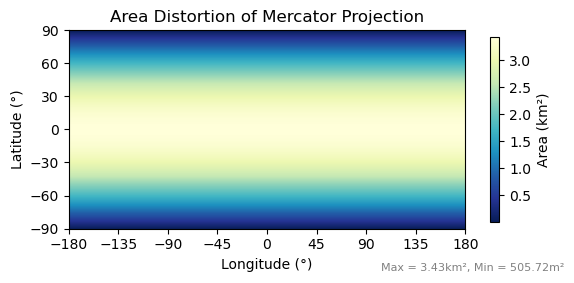

In [2]:
kwds: dict

with rasterio.open('../src/ETOPO.tif') as f:
    kwds = f.profile
    kwds.update(driver = 'GTiff',
                dtype = rasterio.float32)

    with rasterio.open('../src/ETOPO-area.tif',
                       mode = 'w',
                       **kwds) as g:
        g.write_band(1, area_grd.astype(rasterio.float32))

fig1, ax1 = plt.subplots()
im = ax1.imshow(area_grd,
                extent = (-180, 180, -90, 90),
                cmap = 'YlGnBu_r')

cb1 = fig1.colorbar(im,
                    ax = ax1,
                    shrink = 0.5,
                    ticks = np.arange(0, 3.5, 0.5))

cb1.set_label('Area (km²)')
fig1.text(x = 0.9,
          y = 0.2,
          s = f'Max = {round(np.max(area_grd), 2)}km², Min = {round(np.min(area_grd) * 1e6, 2)}m²',
          c = 'grey',
          ha = 'right',
          size = 8)
ax1.set(xlabel = 'Longitude (°)',
        xticks = np.arange(-180, 225, 45),
        ylabel = 'Latitude (°)',
        yticks = np.arange(-90, 120, 30),
        title = 'Area Distortion of Mercator Projection')

plt.show()

# Free memory
del ax1
del cb1
del fig1

### Find the volume of the ocean

To calculate the volume of the ocean (assuming the cells with elevation lower than 0 are filled with water), simply multiply the difference between sea bed and the sea level with the area calculated in previous section. According to the result, the volume of the ocean is about **1.345 billion km³**.  *[Click here](https://github.com/taipeinative/terrain-hydrologic/blob/main/Assignment%201130/Plots/Local%20Volume.png) to see the full image*.

In [3]:
hgt_grd: np.ndarray
sea_grd: np.ndarray

with rasterio.open('../src/ETOPO.tif') as f:
    hgt_grd = f.read(1)

sea_grd = -hgt_grd.copy()
sea_grd[sea_grd < 0] = 0
volume = np.sum(sea_grd * area_grd)
print(f'The volume of the ocean is about {round(volume, 2)} km³.')

The volume of the ocean is about 1345069552298.22 km³.


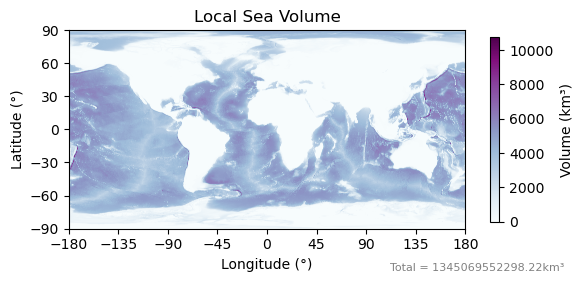

In [4]:
fig2, ax2 = plt.subplots()
im = ax2.imshow(sea_grd,
                extent = (-180, 180, -90, 90),
                cmap = 'BuPu')

cb2 = fig2.colorbar(im,
                    ax = ax2,
                    shrink = 0.5)

cb2.set_label('Volume (km³)')
fig2.text(x = 0.9,
          y = 0.2,
          s = f'Total = {round(volume, 2)}km³',
          c = 'grey',
          ha = 'right',
          size = 8)
ax2.set(xlabel = 'Longitude (°)',
        xticks = np.arange(-180, 225, 45),
        ylabel = 'Latitude (°)',
        yticks = np.arange(-90, 120, 30),
        title = 'Local Sea Volume')

plt.show()

# Free memory
del ax2
del cb2
del fig2
del sea_grd

### Invert global terrain

The inversion of the terrain can be done by simply putting a minus sign. *[Click here](https://github.com/taipeinative/terrain-hydrologic/blob/main/Assignment%201130/Plots/Inverted%20Terrain.png) to see the full image*.

In [ ]:
with rasterio.open('../src/ETOPO-inverted.tif',
                   mode = 'w',
                   **kwds) as g:
    g.write_band(1, (-hgt_grd).astype(rasterio.float32))

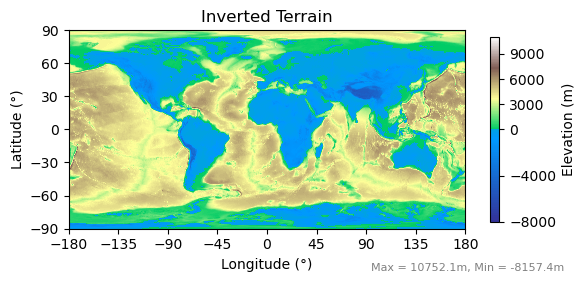

In [5]:
# Create custom colormap
custom_colors = np.vstack((plt.cm.terrain(np.linspace(0, 0.17, 256)), plt.cm.terrain(np.linspace(0.25, 1, 256))))
terrain_cmap = colors.LinearSegmentedColormap.from_list('terrain_cmap', custom_colors)

fig3, ax3 = plt.subplots()
im = ax3.imshow(-hgt_grd,
                extent = (-180, 180, -90, 90),
                cmap = terrain_cmap,
                norm = colors.TwoSlopeNorm(vmin = -8000, vcenter = 0, vmax = 11000))

cb3 = fig3.colorbar(im,
                    ax = ax3,
                    shrink = 0.5,
                    ticks = [-8000, -4000, 0, 3000, 6000, 9000])

cb3.set_label('Elevation (m)')
fig3.text(x = 0.9,
          y = 0.2,
          s = f'Max = {round(float(np.max(-hgt_grd)), 1)}m, Min = {round(float(np.min(-hgt_grd)), 1)}m',
          c = 'grey',
          ha = 'right',
          size = 8)
ax3.set(xlabel = 'Longitude (°)',
        xticks = np.arange(-180, 225, 45),
        ylabel = 'Latitude (°)',
        yticks = np.arange(-90, 120, 30),
        title = 'Inverted Terrain')

plt.show()

# Free memory
del ax3
del cb3
del fig3
del custom_colors

### Retrieve new sea level

In the last task, the ocean water has to be poured back into the inverted DEM. To get the new sea level, the algorithm will keep pouring water until the difference of the volume ratio is under 0.0001% (using [Binary Search](https://en.wikipedia.org/wiki/Binary_search).) According to the result, the new sea level will be **5015.4854m above the old one.**

In [6]:
iterator = 0
ivt_grd: np.ndarray = -hgt_grd
limit_upper: float = np.max(ivt_grd)
limit_lower: float = np.min(ivt_grd)
ratio: float = 0
current_height: float = limit_lower

while (np.abs(ratio - 1) > 1e-6):
    if ratio < 1:
        limit_lower = current_height
        current_height += ((limit_upper - limit_lower) / 2)

    elif ratio > 1:
        limit_upper = current_height
        current_height -= ((limit_upper - limit_lower) / 2)

    tmp_grd = ivt_grd - current_height
    tmp_grd[tmp_grd > 0] = 0
    ratio = -np.sum(tmp_grd * area_grd) / volume
    iterator += 1
    print(f'Run {"{:02d}".format(iterator)} - Height = {"{:.4f}m".format(current_height)}, Percentage = {"{:.4%}".format(ratio)}')

new_hgt_grd = ivt_grd - current_height
print(f'The new sea level is {"{:.4f}m".format(current_height)} (according to old sea level), where new ocean volume is {"{:.4%}".format(ratio)} of current volume.')

# Free memory
del hgt_grd
del tmp_grd

Run 01 - Height = 1297.3623m, Percentage = 24.2709%
Run 02 - Height = 6024.7222m, Percentage = 136.1581%
Run 03 - Height = 3661.0422m, Percentage = 63.8747%
Run 04 - Height = 4842.8823m, Percentage = 94.5248%
Run 05 - Height = 5433.8022m, Percentage = 114.2910%
Run 06 - Height = 5138.3423m, Percentage = 104.0514%
Run 07 - Height = 4990.6123m, Percentage = 99.1954%
Run 08 - Height = 5064.4775m, Percentage = 101.6001%
Run 09 - Height = 5027.5449m, Percentage = 100.3920%
Run 10 - Height = 5009.0786m, Percentage = 99.7923%
Run 11 - Height = 5018.3115m, Percentage = 100.0918%
Run 12 - Height = 5013.6953m, Percentage = 99.9419%
Run 13 - Height = 5016.0034m, Percentage = 100.0168%
Run 14 - Height = 5014.8496m, Percentage = 99.9794%
Run 15 - Height = 5015.4268m, Percentage = 99.9981%
Run 16 - Height = 5015.7148m, Percentage = 100.0075%
Run 17 - Height = 5015.5708m, Percentage = 100.0028%
Run 18 - Height = 5015.4990m, Percentage = 100.0005%
Run 19 - Height = 5015.4629m, Percentage = 99.9993%
Ru

### Write new DEM to GeoTIFF

The next step will be exporting the new global DEM (as `ETOPO-newSeaLevel.tif`) and the map. There are no notable differences between the following codes and the previous ones shown in the chapter [Write area into GeoTIFF](#write-area-into-geotiff). *[Click here](https://github.com/taipeinative/terrain-hydrologic/blob/main/Assignment%201130/Plots/Poured%20Terrain.png) to see the full image*.

In [ ]:
with rasterio.open('../src/ETOPO-newSeaLevel.tif',
                   mode = 'w',
                   **kwds) as g:
    g.write_band(1, new_hgt_grd.astype(rasterio.float32))

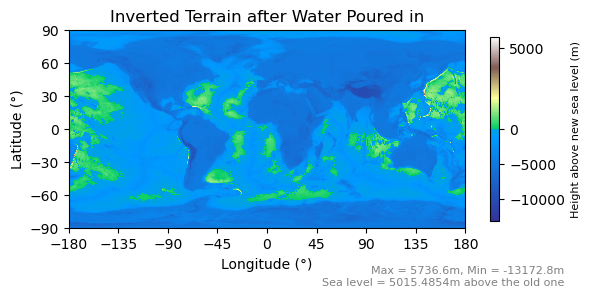

In [7]:
fig4, ax4 = plt.subplots()
im = ax4.imshow(new_hgt_grd,
                extent = (-180, 180, -90, 90),
                cmap = terrain_cmap,
                norm = colors.TwoSlopeNorm(vmin = np.min(new_hgt_grd), vcenter = 0, vmax = np.max(new_hgt_grd)))

cb4 = fig4.colorbar(im,
                    ax = ax4,
                    shrink = 0.5)

cb4.set_label('Height above new sea level (m)',
              size = 8)
fig4.text(x = 0.9,
          y = 0.17,
          s = f'Max = {round(float(np.max(new_hgt_grd)), 1)}m, Min = {round(float(np.min(new_hgt_grd)), 1)}m\nSea level = {"{:.4f}m".format(current_height)} above the old one',
          c = 'grey',
          ha = 'right',
          size = 8)
ax4.set(xlabel = 'Longitude (°)',
        xticks = np.arange(-180, 225, 45),
        ylabel = 'Latitude (°)',
        yticks = np.arange(-90, 120, 30),
        title = 'Inverted Terrain after Water Poured in')

plt.show()

# Free memory
del ax4
del cb4
del fig4
del new_hgt_grd

### Bonus: Animation frames of pouring water into inverted DEM

The following codes generate a series of plots, which can be turned into a gif or a video showing the process adding water into the inverted DEM.

**Warning!** You may want to generate them segmentally, so your memeory won't overflow. *[Click here](https://github.com/taipeinative/terrain-hydrologic/raw/refs/heads/main/Assignment%201130/Animation.mov) to download the premade animation.*

In [ ]:
import os

if not os.path.exists('../src/tmp'):
    os.makedirs('../src/tmp')

kft = np.arange(-8100, 5100, 100)

for i in kft:
    tmp_grd = ivt_grd - i

    fig5, ax5 = plt.subplots()
    im = ax5.imshow(tmp_grd,
                    extent = (-180, 180, -90, 90),
                    cmap = terrain_cmap,
                    norm = colors.TwoSlopeNorm(vmin = np.min(tmp_grd), vcenter = 0, vmax = np.max(tmp_grd)))

    cb5 = fig5.colorbar(im,
                        ax = ax5,
                        shrink = 0.7)

    cb5.set_label('HANS (m)')
    fig5.text(x = 0.9,
              y = 0.08,
              s = 'HANS = height above new sea level',
              c = 'grey',
              ha = 'right',
              size = 8)
    
    tmp_grd[tmp_grd > 0] = 0
    ratio = -np.sum(tmp_grd * area_grd) / volume

    ax5.set(xlabel = 'Longitude (°)',
            xticks = np.arange(-180, 225, 45),
            ylabel = 'Latitude (°)',
            yticks = np.arange(-90, 120, 30),
            title = f'{i}m / {ratio:.2%}')
    
    fig5.set_size_inches(8, 4)

    plt.savefig(f'../src/tmp/{i}.png', bbox_inches = 'tight')
    plt.close()